<a href="https://colab.research.google.com/github/ravichas/AMPL-Tutorial/blob/master/GCP_AMPL_FNL_Wrshp2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMPL Workshop2-1: Exploratory data analysis to create partially curated datasets
> In this notebook we will analyze binding assay measurements for datasets from ChEMBL, DTC and ExCAPE-DB.<br>
ChEMBL: https://www.ebi.ac.uk/chembl/<br>
DTC: https://drugtargetcommons.fimm.fi/<br>
ExCAPE-DB: https://solr.ideaconsult.net/search/excape/<br>
> The target we're working on in this notebook is Histamine Receptor H1 (HRH1) 

In [ ]:
from IPython.display import Image
Image(url='https://github.com/ravichas/AMPL-Tutorial/blob/master/Img/GCP-AMPL-FNL_Wrshp2-1-overview.png?raw=true')

We assume that the AMPL software (https://github.com/ATOMconsortium/AMPL) is already installed. If you want to try AMPL without installing the software, copy the notebook to your google drive and run the notebook in Google COLAB. 

If you are running the notebook in Google COLAB, please uncomment and run the following two code cells to install AMPL.

## AMPL Installation (only for Google COLAB environments)

Uncomment/run the following two code chunks

In [ ]:
# ! pip install rdkit-pypi
# ! pip install --pre deepchem

# import deepchem
# # print(deepchem.__version__)
# ! pip install umap
# ! pip install llvmlite==0.35.0  --ignore-installed
# ! pip install umap-learn
# ! pip install molvs
# ! pip install bravado

In [ ]:
# import deepchem as dc

# # get the Install AMPL_GPU_test.sh
# !wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# # run the script to install AMPL
# ! chmod u+x install_AMPL_GPU_test.sh
# ! ./install_AMPL_GPU_test.sh

## Load packages

In [ ]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
from atomsci.ddm.utils import struct_utils
from atomsci.ddm.utils import curate_data
from atomsci.ddm.pipeline import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set pandas options
pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

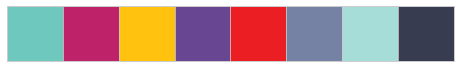

In [ ]:
# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10,10]

colors = [
    "#6EC8BE",
    "#BE2369",
    "#FFC30F",
    "#694691",
    "#EB1E23",
    "#7682A4",
    "#A7DDD8",
    "#373C50",
]
# Set your custom color palette
pal=sns.color_palette(colors)
sns.set_palette(pal)
sns.palplot(pal)

## Input files needed for this notebook

These files will be downloaded from a GitHub repository.

> __`hrh1_chembl.csv`__<br>
> __`hrh1_dtc.csv`__<br>
> __`hrh1_excape.csv`__<br>
> __`1591412781568494159.txt`__<br>
> __`904065732039684223.txt`__<br>

## Load data

In [ ]:
! wget -O hrh1_chembl.csv https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/hrh1_chembl.csv >& /dev/null
chembl = pd.read_csv("hrh1_chembl.csv", sep=';')

# Examine data
> __What molecular (and other) identifiers exist for compounds from each database?__<br>
> __What assay response types are there in each file?__<br>
> __How we might combine these data sources together?__<br>

In [ ]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces in column names
print(chembl.shape)

(5341, 45)


In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL157217,NaN,0,277.46,0,4.17,1j,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Ki,'=',2.511886e+14,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL692992,Inhibitory activity against human Histamine H1...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1145948,1,Scientific Literature,J. Med. Chem.,2003.0,None,NaN
1,CHEMBL307115,NaN,0,557.70,1,1.84,16,CNC(=O)CNC(=O)C(Cc1ccccc1)N(NC(=O)CCCC(C)NCCc1...,Change,'=',0.000000e+00,%,NaN,NaN,NaN,UO_0000187,NaN,NaN,NaN,NaN,False,CHEMBL699237,Effect on peripheral vasculature of the rabbit...,F,BAO_0000221,tissue-based format,Oryctolagus cuniculus,CHEMBL3988033,Vasculature,None,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1123649,1,Scientific Literature,J. Med. Chem.,1987.0,None,NaN
2,CHEMBL444083,NaN,0,562.66,2,5.04,1,NC(=O)N(O)CCC#Cc1ccc(OCCCCN2CCN(C(c3ccc(F)cc3)...,Ki,'=',3.630000e+00,nM,8.44,NaN,NaN,UO_0000065,15.0,0.28,3.40,10.26,False,CHEMBL828761,Binding affinity for recombinant human Histami...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1141893,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3308072,NaN


In [ ]:
pd.DataFrame(chembl.Standard_Type.value_counts()).T

,Ki,IC50,Inhibition,Activity,pKb,EC50,Intrinsic activity,Kd,pEC50,Kb,Alpha,Activity_index,pKB,Effect,Change,Log IC50,pKi,% Ctrl,% Inhibition of Control Specific Binding (Mean n=2),Emax,Efficacy,pIC50,TIME,% Inhibition of Control Agonist Response (Mean n=2),K,% of Control Agonist Response (Mean n=2),Ratio,p[A50],pKp,Mean fold stimulation,KB,Inhibition (% of control),Activation (% of control),Log EC50,Selectivity ratio
Standard_Type,2550,1281,690,192,128,77,68,52,47,47,41,24,22,20,19,18,17,9,8,5,4,3,3,2,2,2,2,1,1,1,1,1,1,1,1


## Curation Step: Subset data for the standard types you want to keep
> __ML algorithms need lots of data, in general keep the most abundant types__<br>
> __IC50, Log IC50, pIC50 may be combined with proper care__<br>

In [ ]:
print(chembl.shape)
chembl = chembl[chembl.Standard_Type.isin(['Ki', 'IC50', 'EC50'])]
chembl.shape

(5341, 45)


(3908, 45)

### Examine assay types

In [ ]:
assays = pd.DataFrame(chembl[chembl.Standard_Type=='Ki'].Assay_Description.value_counts()).reset_index()
assays.columns=['Assay_Description', 'count']
assays.to_csv('HRH1_ChEMBL_Assays_Ki.csv')
print('Ki assays:')
display(assays)

Ki assays:


,Assay_Description,count
0,"DRUGMATRIX: Histamine H1, Central radioligand ...",871
1,Antagonist activity at histamine H1 receptor b...,115
2,Binding affinity to histamine H1 receptor,93
3,Binding affinity for the human Histamine H1 Re...,58
4,Binding affinity towards Histamine H1 receptor...,54
...,...,...
146,Displacement of [3H]Pyrilamine from human hist...,1
147,Displacement of [3H]pyrilamine from human H1 r...,1
148,Displacement of radiolabeled pyrilamine from h...,1
149,Binding affinity towards histamine H1 receptor...,1


In [ ]:
assays = pd.DataFrame(chembl[chembl.Standard_Type.isin(['IC50', 'EC50'])].Assay_Description.value_counts()).reset_index()
assays.columns=['Assay_Description', 'count']
assays.to_csv('HRH1_ChEMBL_Assays_XC50.csv')
print('XC50 assays:')
display(assays)

XC50 assays:


,Assay_Description,count
0,"DRUGMATRIX: Histamine H1, Central radioligand ...",871
1,Antagonistic activity against histamine H1 rec...,38
2,Agonist activity at human histamine H1 recepto...,27
3,Antagonism of the human histamine H1 receptor,24
4,Antagonist activity at human histamine H1 rece...,24
...,...,...
70,Agonist activity at histamine H1 receptor,1
71,Binding affinity to human recombinant histamin...,1
72,Antagonist activity at human histamine H1 rece...,1
73,Displacement of [3H]pyrilamine from human reco...,1


## Exercise: Explore datasets
> load dtc and excape datasets<br>
> explore the loaded (dtc and excape) dataframes to answer the following questions<br>

## Possible list of questions:
> How many assay values in each dataset?<br>
> What are the molecular identifiers from each dataset?<br>
> What are the data types from each dataset?<br>
> What are the data units available from each dataset?<br>
> What is the formula to translate IC50 to pIC50? (Hint: Check the following wikipedia link, https://en.wikipedia.org/wiki/IC50)<br>
> __What kinds of assays are represented in the datasets?<br>

---
### Load DTC data

In [ ]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/hrh1_dtc.csv >& /dev/null
dtc = pd.read_csv("hrh1_dtc.csv")


<div class="alert alert-success">
    <b>DTC Exercise-1: EDA of DTC dataset </b>:
    <it>
    <li> Replace column name empty spaces with "_"
    <li> Print the dimensions of the dataframe
    <li> Filter the dataset to retain only standard types, KI, Ki, IC50, EC50 
    <li> How many unique values of standard types are available?
            
</div>

<div class="alert alert-info">
    <b> Solution for DTC Exercise-1: Try on your own. If you want to see the solution, uncomment the following lines by removing the pound (#) sign and run it to display the code. Then copy the code and paste it in the following empty code cell and run the cell </b>
    
</div>

###  To see the solution, run the following cell and copy the output into a new cell and run them. 

In [ ]:
# ! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/solutions/dtc_solutions1.py >& /dev/null
# ! cat dtc_solutions1.py

---
### Load ExCAPE-DB data

In [ ]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/hrh1_excape.csv >& /dev/null
excape = pd.read_csv("hrh1_excape.csv")

<div class="alert alert-success">
    <b>Excape Exercise-1: EDA of ExCAPE-DB dataset</b>:
    <it>
    <li> Replace column name empty spaces with "_"
    <li> Print the dimensions of the dataframe
    <li> Explore assay information
</div>

<div class="alert alert-info">
    <b> Solution for Excape Exercise-1: Try on your own. If you want to see the solution, uncomment the following lines by removing the pound (#) sign and run it to display the code. Then copy the code and paste it in the following empty code cell and run the cell </b>
    
</div>

In [ ]:
# ! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/solutions/excape_solutions1.py >& /dev/null
# ! cat excape_solutions1.py

# EDA: Assay data responses
> __What type of variable are the data responses?__<br>
> __What kind of ML model would you build to predict this data?__<br>
> __What kind of visualizations & analysis can you use to understand more about the data?__<br>

In [ ]:
chembl.tail(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
5326,CHEMBL3337895,NaN,0,448.55,0,3.56,None,COc1cccc(CNC(=O)c2nc3scc(CN(C)Cc4ccccc4)c3c(=O...,Ki,'=',19.00,nM,7.72,NaN,NaN,UO_0000065,17.21,0.33,4.16,8.84,False,CHEMBL4507824,GPCRScan assay: inhibition of H1,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 9794809/792...,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507300,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,NaN
5330,CHEMBL440687,NaN,0,293.37,0,2.28,None,c1ccc(N2CCN(Cc3nc4ccccc4[nH]3)CC2)nc1,Ki,'=',6760.83,nM,5.17,NaN,NaN,UO_0000065,17.62,0.32,2.89,10.76,False,CHEMBL4507824,GPCRScan assay: inhibition of H1,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,Parental cells: stable HEK | PMID: 9794809/792...,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507260,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,NaN
5331,CHEMBL1651534,PF-04457845,2,455.44,1,5.39,PF-04457845,O=C(Nc1cccnn1)N1CCC(=Cc2cccc(Oc3ccc(C(F)(F)F)c...,Ki,'=',0.00,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4510786,H1 (h) CEREP ligand profiling,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL4507297,54,Donated Chemical Probes - SGC Frankfurt,NaN,NaN,None,NaN


In [ ]:
chembl.Standard_Units.unique()

array(['nM', nan], dtype=object)

In [ ]:
chembl.Standard_Relation.unique()

array(["'='", nan, "'>'", "'<'", "'~'"], dtype=object)

## **Curation step**: Change `Standard Units` to be the same for all responses. 
> __This task may not be necessary for HRH1, but might be essential for other datasets__<br>
> __create the column anyway for use later__<br>

In [ ]:
chembl['Standard_Units'].value_counts()

nM    2149
Name: Standard_Units, dtype: int64

In [ ]:
# change uM to nM units so they're all the same
chembl.loc[:, 'Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',    # where units are uM,
                                              chembl.Standard_Value * 1000, # multiply Standard_Value by 1000, 
                                              chembl.Standard_Value)        # otherwise take the Standard_Value

## EDA: Summarize, describe, plot data for analysis

In [ ]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,3908.000000,2.149000e+03,1745.000000,1355.000000,3908.000000,2144.000000,2.149000e+03
mean,1.542477,2.867579e+14,6.959989,19.275137,7.714176,2009.235541,2.867579e+14
std,1.918612,1.102390e+16,1.280191,7.063546,8.027240,5.344678,1.102390e+16
min,0.000000,0.000000e+00,4.000000,8.120000,1.000000,1991.000000,0.000000e+00
25%,0.000000,1.780000e+01,6.000000,14.255000,1.000000,2005.000000,1.780000e+01
50%,0.000000,3.110000e+02,6.980000,17.100000,1.000000,2010.000000,3.110000e+02
75%,4.000000,2.511890e+03,8.000000,23.755000,15.000000,2012.000000,2.511890e+03
max,4.000000,5.011872e+17,10.850000,70.950000,54.000000,2020.000000,5.011872e+17


In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM
0,CHEMBL157217,NaN,0,277.46,0,4.17,1j,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Ki,'=',2.511886e+14,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL692992,Inhibitory activity against human Histamine H1...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1145948,1,Scientific Literature,J. Med. Chem.,2003.0,None,NaN,2.511886e+14
2,CHEMBL444083,NaN,0,562.66,2,5.04,1,NC(=O)N(O)CCC#Cc1ccc(OCCCCN2CCN(C(c3ccc(F)cc3)...,Ki,'=',3.630000e+00,nM,8.44,NaN,NaN,UO_0000065,15.00,0.28,3.40,10.26,False,CHEMBL828761,Binding affinity for recombinant human Histami...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1141893,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3308072,NaN,3.630000e+00
3,CHEMBL101691,NaN,0,428.55,0,3.10,33,O=C(c1ccc(OCCCN2CC[C@H](NS(=O)(=O)c3ccccc3)C2)...,Ki,'=',9.100000e+03,nM,5.04,NaN,NaN,UO_0000065,11.76,0.23,1.94,6.66,False,CHEMBL691613,Binding affinity to the human Histamine H1 rec...,B,BAO_0000357,single protein format,None,None,None,None,None,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1134928,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,None,NaN,9.100000e+03


**Why do some columns seem numeric (ex., Molecular Weight, AlogP etc)  but not listed in the `describe()` command? Examine chembl csv file. The reason for this behavior is due to some cells for these columns contain `None` entries that make it an `object` datatype rather than `float64`**

In [ ]:
chembl=chembl.replace('None',np.nan)

In [ ]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase', 'Molecular_Weight', 
              '#RO5_Violations', 'AlogP', 
              'Standard_Value_nM', 'pChEMBL_Value']
for col in numeric_cols:
    chembl[col]=chembl[col].astype(float)

In [ ]:
chembl.head(5)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM
0,CHEMBL157217,NaN,0.0,277.46,0.0,4.17,1j,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Ki,'=',2.511886e+14,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL692992,Inhibitory activity against human Histamine H1...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1145948,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,2.511886e+14
2,CHEMBL444083,NaN,0.0,562.66,2.0,5.04,1,NC(=O)N(O)CCC#Cc1ccc(OCCCCN2CCN(C(c3ccc(F)cc3)...,Ki,'=',3.630000e+00,nM,8.44,NaN,NaN,UO_0000065,15.00,0.28,3.40,10.26,False,CHEMBL828761,Binding affinity for recombinant human Histami...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,CHO,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1141893,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3308072,NaN,3.630000e+00
3,CHEMBL101691,NaN,0.0,428.55,0.0,3.10,33,O=C(c1ccc(OCCCN2CC[C@H](NS(=O)(=O)c3ccccc3)C2)...,Ki,'=',9.100000e+03,nM,5.04,NaN,NaN,UO_0000065,11.76,0.23,1.94,6.66,False,CHEMBL691613,Binding affinity to the human Histamine H1 rec...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1134928,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,NaN,NaN,9.100000e+03
4,CHEMBL420108,NaN,0.0,453.56,0.0,2.97,40,N#Cc1ccccc1S(=O)(=O)N[C@H]1CCN(CCCOc2ccc(C(=O)...,Ki,'=',6.200000e+03,nM,5.21,NaN,NaN,UO_0000065,11.48,0.22,2.24,5.23,False,CHEMBL691613,Binding affinity to the human Histamine H1 rec...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1134928,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,NaN,NaN,6.200000e+03
6,CHEMBL172233,NaN,0.0,324.44,0.0,4.49,20,CC(C1=C(CCN(C)CCF)Cc2ccccc21)c1ccccn1,Ki,'=',7.244000e+00,nM,8.14,NaN,NaN,UO_0000065,25.09,0.46,3.65,50.47,False,CHEMBL692990,Compound was evaluated for binding affinity to...,B,BAO_0000219,cell-based format,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1136812,1,Scientific Literature,J. Med. Chem.,2003.0,CHEMBL3307512,NaN,7.244000e+00


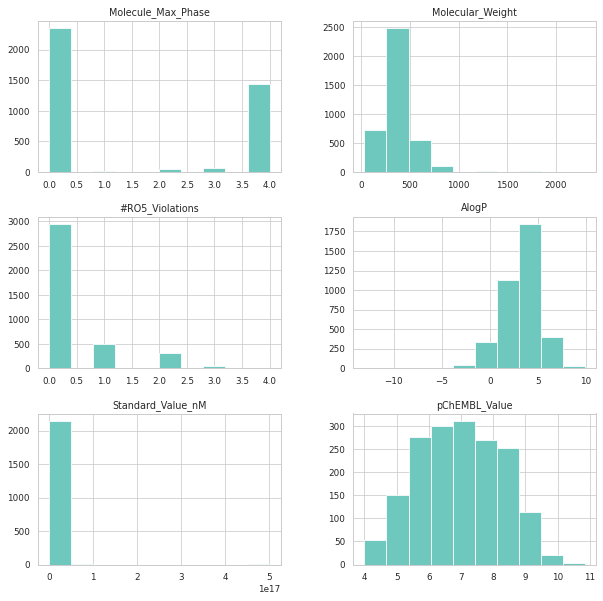

In [ ]:
chembl[numeric_cols].hist(figsize=(10,10));

> __Note that pChembl value is better normalized than standard value__<br>
> __Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:__<br>

Standard_Type,EC50,IC50,Ki
count,42.000000,361.000000,1.451000e+03
mean,5807.889939,7630.341078,1.106850e+14
std,8720.786746,46197.420774,2.886940e+15
min,0.000100,0.421000,0.000000e+00
25%,3.640250,32.000000,2.512000e+01
50%,1943.000000,239.665000,5.011900e+02
75%,10000.000000,2070.000000,3.162280e+03
max,50000.000000,750115.000000,1.000000e+17


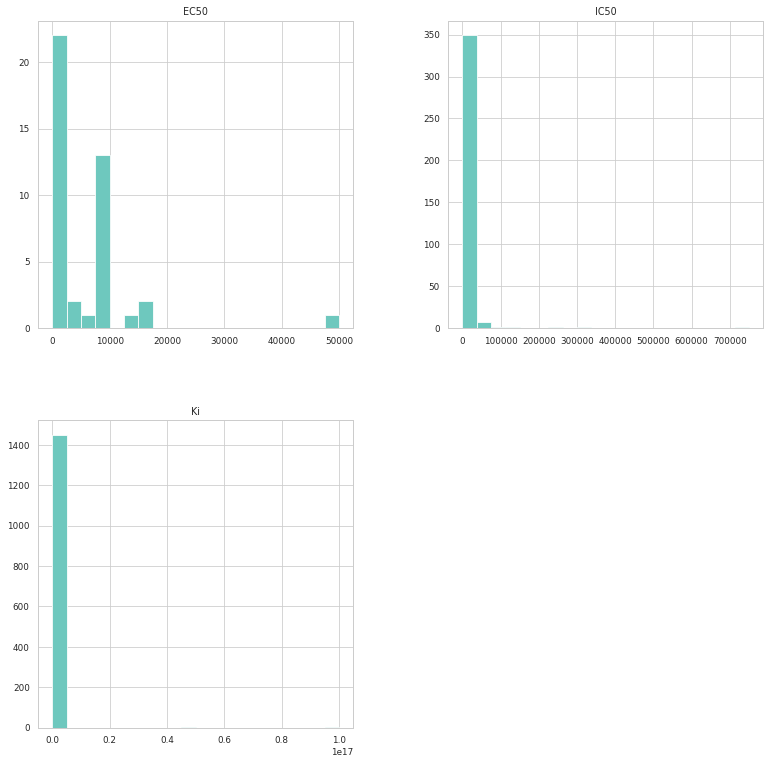

In [ ]:
# examine STANDARD values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13), bins = 20);

- **What do you notice about the standard values?**

Standard_Type,EC50,IC50,Ki
count,19.000000,302.000000,1149.000000
mean,6.369883,6.932082,6.899663
std,1.289900,1.083643,1.287188
min,4.800000,4.300000,4.000000
25%,5.525000,6.100000,5.900000
50%,6.080000,7.022500,6.920000
75%,6.983889,7.795000,7.850000
max,9.400000,9.380000,10.310000


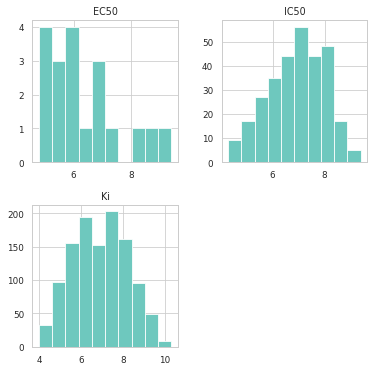

In [ ]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', 
                                columns = 'Standard_Type', 
                                values='pChEMBL_Value', 
                                aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

<div class="alert alert-success">
    <b>DTC-Exercise 2: Explore DTC dataset </b>:
            
</div>

<div class="alert alert-info">
    <b> Solution for DTC Exercise-2: Try on your own. If you want to see the solution, uncomment the following lines by removing the pound (#) sign and run it to display the code. Then copy the code and paste it in the following empty code cell and run the cell </b>
    
</div>

In [ ]:
# ! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/solutions/dtc_solutions2.py >& /dev/null
# ! cat dtc_solutions2.py

<div class="alert alert-success">
    <b>Excape Exercise 2: Explore ExCAPE-DB dataset </b>:
            
</div>

<div class="alert alert-info">
    <b> Solution for ExCAPE Exercise-2: Try on your own. If you want to see the solution, uncomment the following lines by removing the pound (#) sign and run it to display the code. Then copy the code and paste it in the following empty code cell and run the cell </b>
    
</div>

In [ ]:
! wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/solutions/excape_solutions2.py >& /dev/null
! cat excape_solutions2.py

excape=excape.replace('None', np.nan)
excape.head()

# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,1283.000000,1268.000000,1.283000e+03,1283.000000,1283.0
mean,5299.410756,7.007668,5.353520e+05,9654.893219,2055.0
std,6237.774346,1.310143,3.051988e+05,150.208457,0.0
min,3269.000000,3.500000,8.441800e+04,9606.000000,2055.0
25%,3269.000000,5.967500,3.028830e+05,9606.000000,2055.0
50%,3269.000000,7.100000,5.945670e+05,9606.000000,2055.0
75%,3269.000000,8.050000,7.671370e+05,9606.000000,2055.0
max,24448.000000,11.520000,1.365249e+06,10116.000000,2055.0


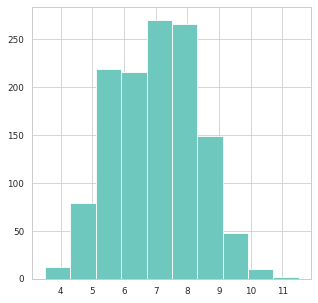

In [ ]:
excape=excape.replace('None', np.nan)
excape.head()

# excape only has one column we care about
display(excape.describe())
excape.pXC50.hist(figsize=(5,5));

## Exercise: compare pResponse values across all three datasets
- which responses can you compare across all three datasets?
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot
- (try later) use numpy's `arange()` function with the `bins` argument in the `distplot` function to create equal sized bins for every dataset (find information on how to specify bins here: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)

In [ ]:
chembl.head(3)

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM
0,CHEMBL157217,NaN,0.0,277.46,0.0,4.17,1j,c1nc(CCCCCCCCCCN2CCCC2)c[nH]1,Ki,'=',2.511886e+14,nM,NaN,Outside typical range,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL692992,Inhibitory activity against human Histamine H1...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1145948,1,Scientific Literature,J. Med. Chem.,2003.0,NaN,NaN,2.511886e+14
2,CHEMBL444083,NaN,0.0,562.66,2.0,5.04,1,NC(=O)N(O)CCC#Cc1ccc(OCCCCN2CCN(C(c3ccc(F)cc3)...,Ki,'=',3.630000e+00,nM,8.44,NaN,NaN,UO_0000065,15.00,0.28,3.40,10.26,False,CHEMBL828761,Binding affinity for recombinant human Histami...,B,BAO_0000219,cell-based format,Homo sapiens,NaN,NaN,CHO,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1141893,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2005.0,CHEMBL3308072,NaN,3.630000e+00
3,CHEMBL101691,NaN,0.0,428.55,0.0,3.10,33,O=C(c1ccc(OCCCN2CC[C@H](NS(=O)(=O)c3ccccc3)C2)...,Ki,'=',9.100000e+03,nM,5.04,NaN,NaN,UO_0000065,11.76,0.23,1.94,6.66,False,CHEMBL691613,Binding affinity to the human Histamine H1 rec...,B,BAO_0000357,single protein format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL231,Histamine H1 receptor,Homo sapiens,SINGLE PROTEIN,CHEMBL1134928,1,Scientific Literature,Bioorg. Med. Chem. Lett.,2002.0,NaN,NaN,9.100000e+03


In [ ]:
chembl.Standard_Type.unique()

array(['Ki', 'IC50', 'EC50'], dtype=object)

In [ ]:
dtc.standard_type.unique()

array(['IC50', 'Ki', 'EC50'], dtype=object)

In [ ]:
excape.shape

(1283, 11)

---
## Histogram plot

https://seaborn.pydata.org/generated/seaborn.histplot.html

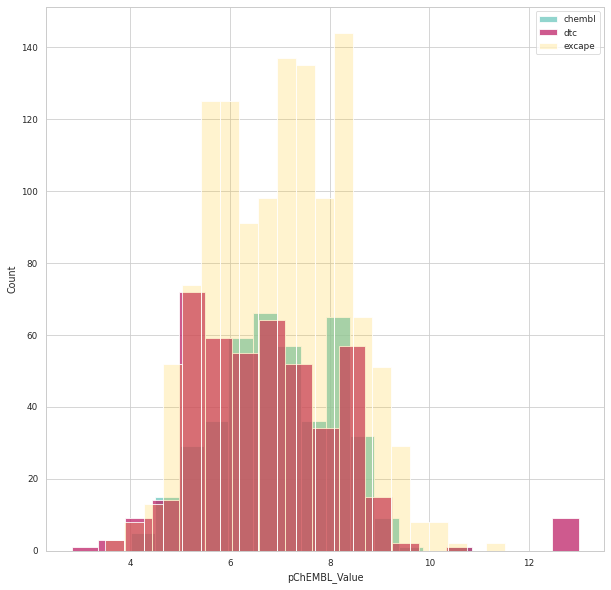

In [ ]:
fig, ax = plt.subplots(1, sharex=True, figsize=(10,10))
sns.histplot(data=chembl[chembl.Standard_Type.isin(['IC50', 'EC50'])], x='pChEMBL_Value', ax=ax, color=pal[0])
sns.histplot(dtc[dtc.standard_type.isin(['IC50', 'EC50'])].pDTC_Value, ax=ax, color=pal[1])
sns.histplot(excape.pXC50, ax=ax, color=pal[2], alpha = 0.2)
ax.legend(labels=['chembl', 'dtc', 'excape']);

---
## KDE Plot

"A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions." taken from https://seaborn.pydata.org/generated/seaborn.kdeplot.html

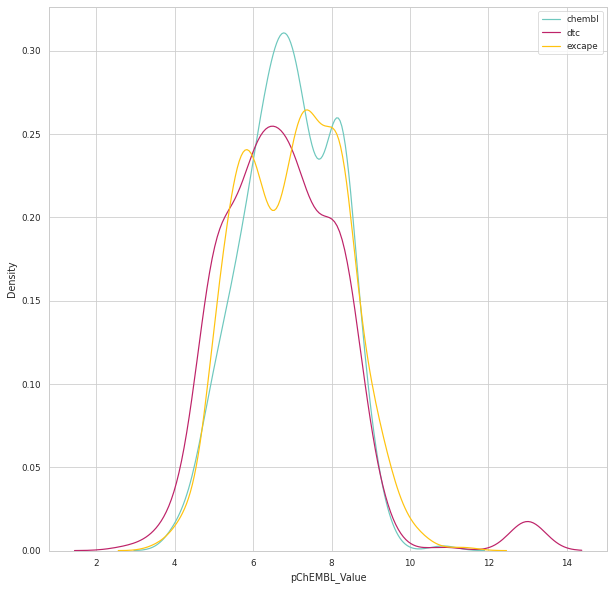

In [ ]:
fig, ax = plt.subplots(1, sharex=True, figsize=(10,10))
sns.kdeplot(data=chembl[chembl.Standard_Type.isin(['IC50', 'EC50'])], x='pChEMBL_Value', ax=ax, color=pal[0])
sns.kdeplot(dtc[dtc.standard_type.isin(['IC50', 'EC50'])].pDTC_Value, ax=ax, color=pal[1])
sns.kdeplot(excape.pXC50, ax=ax, color=pal[2])
ax.legend(labels=['chembl', 'dtc', 'excape']);

## Exercise: analysis
- What value types you would model and why?
- How would you use this data for a classification model?

- For this dataset we could model either pXC50 or pKI values. They are the most abundant in the dataset and commonly used for modeling. pKI is more normally distributed, but pXC50 values allow inclusion of excape data. 

According to some sources, these two datapoints can be combined in various ways, as well, but that's beyond the scope of this class.

- For this dataset, one could choose a reasonable IC50 concentration to use as a threshold (perhaps 10uM, or consult an experimental scientist), and anything with an IC50 `above` that threshold is `inactive` and IC50s `below` this threshold is `active`.

# DTC: Fill in empty SMILES string using InChi Keys

In [ ]:
dtc.head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value
0,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN
1,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,Ki,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN
2,CHEMBL1090526,ABDWUBPDHWDFCV-CYBMUJFWSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,20227880.0,Ki,=,0.7,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity at histamine H1 receptor,Selectivity profiling of novel indene H(1)-ant...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,9.154902


Let us start with `compound_id` column and try to convert them to SMILES string using PubChem ID Exchange service

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers

In [ ]:
dtc['compound_id'].head(5)

0         CHEMBL12
1         CHEMBL12
2    CHEMBL1090526
3    CHEMBL1090526
4      CHEMBL60435
Name: compound_id, dtype: object

In [ ]:
dtc['standard_inchi_key'].isna().sum()

152

In [ ]:
dtc['compound_id'].isna().sum()

44

Since AMPL uses SMILES strings as input, we will use them as our primary data curation tool.
1. open DTC file in excel or google sheets
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
    * Did you get the whole column??
    * Be sure to select the correct `registry ID` for the input id list (see below for a screenshot of PubChem)
    * Select `Operator_type` as `Same CID` and `Ouput IDs` as "SMILES" 
3. upload the resulting text file from `PubChem Identifier Exchange Service` into jupyter

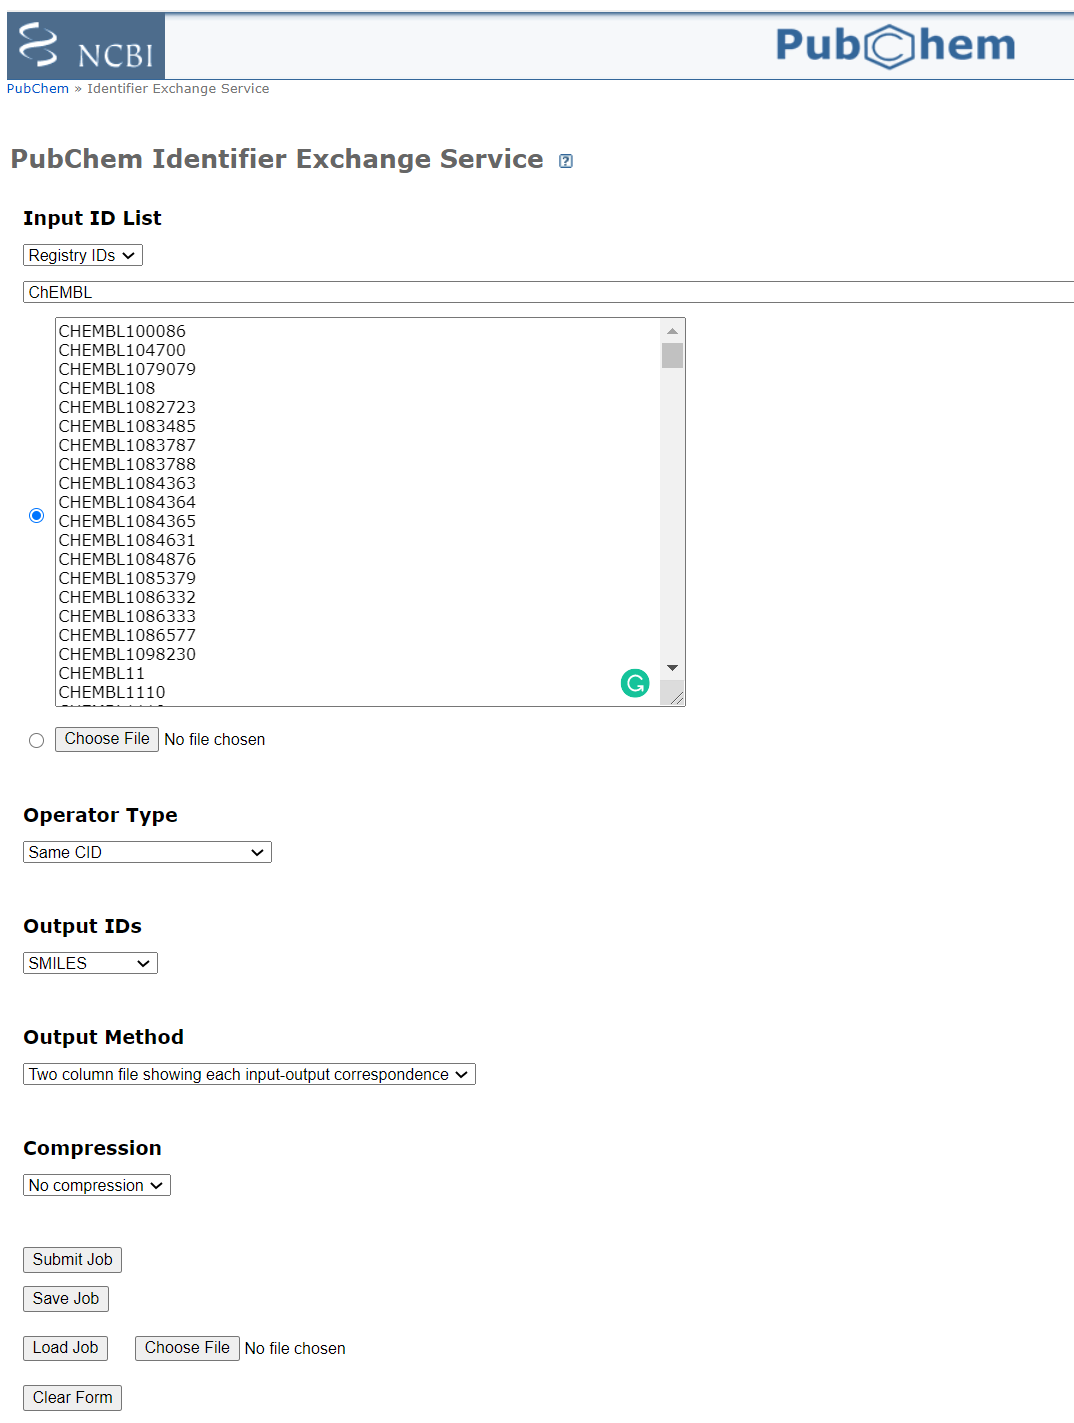

In [ ]:
from IPython.display import Image
Image("https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/Img/PubChemCIDExchange.png", 
      width = 900, height = 900)

In [ ]:
# open file from pubchem ID exchange service
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/1591412781568494159.txt >& /dev/null
dtc_smiles = pd.read_csv("1591412781568494159.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
1,CHEMBL10,CS(=O)C1=CC=C(C=C1)C2=NC(=C(N2)C3=CC=NC=C3)C4=...
2,CHEMBL1000,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl
3,CHEMBL1000,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl
4,CHEMBL1000,C1CN(CCN1CCOCC(=O)O)C(C2=CC=CC=C2)C3=CC=C(C=C3)Cl


In [ ]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['compound_id'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [ ]:
# what's missing?
print("Number of compounds in dtc: ", dtc_smiles.shape[0])
print("DTC compounds that dont have Chembl IDs:", len(dtc[dtc['compound_id'].isna()]))
print("DTC compounds after convertion have No SMILES string:", len(dtc[dtc.SMILES.isna()]))

Number of compounds in dtc:  4774
DTC compounds that dont have Chembl IDs: 44
DTC compounds after convertion have No SMILES string: 110


In [ ]:
dtc[dtc.SMILES.isna()].head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES
12,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,-1.0,IC50,=,11000.0,NM,NaN,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.958607,NaN
13,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,-1.0,IC50,=,17000.0,NM,NaN,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.769551,NaN
14,NaN,ABZSPJVXTTUFAA-UHFFFAOYSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,-1.0,IC50,=,23000.0,NM,NaN,NaN,NaN,binding,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.638272,NaN


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [ ]:
# try it yourself here

In [ ]:
# select inchikeys from the 110 missing smiles rows
dtc[dtc.SMILES.isna()]['standard_inchi_key'].unique().tolist()

['ABZSPJVXTTUFAA-UHFFFAOYSA-N',
 'FERVXSHGEVPGHF-UHFFFAOYSA-N',
 'FTCWKSGDHXCEMZ-UHFFFAOYSA-N',
 'HXTGXYRHXAGCFP-UHFFFAOYSA-N',
 'IHIXIJGXTJIKRB-UHFFFAOYSA-N',
 'KIWQWJKWBHZMDT-GSVOUGTGSA-N',
 'PDNJLMZEGXHSCU-GSVOUGTGSA-N',
 'QUROTGLADLKIIK-UHFFFAOYSA-N',
 'SUGVYNSRNKFXQM-ACSDJOOWSA-N',
 'VBOQYPQEPHKASR-GSVOUGTGSA-N',
 'VGFZCFWVSYIXEK-UHFFFAOYSA-N',
 'VQOXZBDYSJBXMA-VHFLTRTASA-N',
 'ZQAHOENZMFACFJ-UHFFFAOYSA-N',
 nan]

#### Copy the following `standard_inchi_key` ids into PubChem exchange service and convert it to SMILES
```
ABZSPJVXTTUFAA-UHFFFAOYSA-N
FERVXSHGEVPGHF-UHFFFAOYSA-N
FTCWKSGDHXCEMZ-UHFFFAOYSA-N
HXTGXYRHXAGCFP-UHFFFAOYSA-N
IHIXIJGXTJIKRB-UHFFFAOYSA-N
KIWQWJKWBHZMDT-GSVOUGTGSA-N
PDNJLMZEGXHSCU-GSVOUGTGSA-N
QUROTGLADLKIIK-UHFFFAOYSA-N
SUGVYNSRNKFXQM-ACSDJOOWSA-N
TXZPMHLMPKIUGK-UHFFFAOYSA-N
VBOQYPQEPHKASR-GSVOUGTGSA-N
VGFZCFWVSYIXEK-UHFFFAOYSA-N
VQOXZBDYSJBXMA-VHFLTRTASA-N
ZQAHOENZMFACFJ-UHFFFAOYSA-N
```

In [ ]:
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/datasets/904065732039684223.txt >& /dev/null
inchi_smiles = pd.read_csv("904065732039684223.txt", sep='\t', header=None)
inchi_smiles=inchi_smiles.rename(columns = {0:'INCHIKEY',1:'SMILES'})
inchi_smiles.head(3)

,INCHIKEY,SMILES
0,ABZSPJVXTTUFAA-UHFFFAOYSA-N,CC(=O)NC1=CC=C(C=C1)C(=O)NC2=C(C=CC(=C2)C3=CC=...
1,FERVXSHGEVPGHF-UHFFFAOYSA-N,CC1=CC=C(C=C1)C(C2=CC=CC=C2)OCC[N+](C)(C)C
2,FTCWKSGDHXCEMZ-UHFFFAOYSA-N,CC1CC(C2=CC=CC=C2N1C(=O)C3=CC=CC=C3)N(C4=CC=CC...


In [ ]:
dtc.head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES
0,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,IC50,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3
1,CHEMBL12,AAOVKJBEBIDNHE-UHFFFAOYSA-N,DIAZEPAM,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,NaN,Ki,NaN,NaN,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,NaN,NaN,NaN,NaN,NaN,NaN,CHO-K1,NaN,NaN,NaN,NaN,NaN,NaN,"DRUGMATRIX: Histamine H1, Central radioligand ...",DrugMatrix in vitro pharmacology data,NaN,DATASET,NaN,NaN,CN1C(=O)CN=C(C2=C1C=CC(=C2)Cl)C3=CC=CC=C3
2,CHEMBL1090526,ABDWUBPDHWDFCV-CYBMUJFWSA-N,NaN,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,20227880.0,Ki,=,0.7,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Binding affinity at histamine H1 receptor,Selectivity profiling of novel indene H(1)-ant...,Bioorg. Med. Chem. Lett.,PUBLICATION,NaN,9.154902,C[C@H](C1=C(CC2=C1C=CC(=C2)F)CCN(C)C)C3=NC=CN=...


In [ ]:
# map inchikey to smiles using a dict - map ONLY where there are NA values, don't overwrite existing smiles!
dtc.loc[dtc.SMILES.isna(), 'SMILES'] = dtc.loc[dtc.SMILES.isna(), 'standard_inchi_key'].map(dict(zip(inchi_smiles.INCHIKEY, inchi_smiles.SMILES)))

# what's missing?
print("No InchiKey in DTC:", len(dtc[dtc['standard_inchi_key'].isna()]))
print("No SMILES from InchiKey or ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No InchiKey in DTC: 152
No SMILES from InchiKey or ChemblID in DTC: 66


Pubchem doesn't ID some of these compounds. Depending on how precious your data is and how many data points are missing, it may be worth going to other sources manually, such as chemspider: http://www.chemspider.com/Search.aspx?q=InChIKey=BXTUHNWXQLWICJ-DIXMSKSGSA-L

In [ ]:
dtc[dtc.SMILES.isna()].head(3)

,compound_id,standard_inchi_key,compound_name,synonym,target_id,target_pref_name,gene_names,wildtype_or_mutant,mutation_info,pubmed_id,standard_type,standard_relation,standard_value,standard_units,activity_comment,ep_action_mode,assay_format,assaytype,assay_subtype,inhibitor_type,detection_tech,assay_cell_line,compound_concentration_value,compound_concentration_value_unit,substrate_type,substrate_relation,substrate_value,substrate_units,assay_description,title,journal,doc_type,annotation_comments,pDTC_Value,SMILES
4538,NaN,ZQAHOENZMFACFJ-UHFFFAOYSA-N,AC1O5RVW,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,6146381.0,Ki,=,1200.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.920819,NaN
4539,NaN,ZQAHOENZMFACFJ-UHFFFAOYSA-N,AC1O5RVW,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,11809864.0,Ki,=,2.51,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.600326,NaN
4540,NaN,ZQAHOENZMFACFJ-UHFFFAOYSA-N,AC1O5RVW,NaN,P35367,HISTAMINE H1 RECEPTOR,HRH1,NaN,NaN,12065734.0,Ki,=,211.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.675718,NaN


## Save partially curated files

In [ ]:
chembl.to_csv('HRH1_ChEMBL_sel.csv')

In [ ]:
## If you have completed curating DTC and ExCAPE-DB, you can save them with the following command:

In [ ]:
dtc.to_csv('HRH1_DTC_sel.csv')
excape.to_csv('HRH1_Excape_sel.csv')